---

### **Previsão de Trajetória com Corpo Gravitacional usando Redes Neurais**

Esse projeto tem o objetivo de criar um modelo de redes neurais capaz de, dado um cenário bidimensional com:
- Um corpo gravitacional em uma posição ($\alpha$,$\beta$) (m,m) e massa $M$ (kg);
- Uma posição objetivo ($x$,$y$) (m,m) no espaço;

Queremos prever valores de:
- Velocidade ($v$) (m/s);
- Direção ($\theta$) (rad);
- Tempo ($t$) (s);

De modo que ao lançar um projétil:
- Partindo da posição ($0$,$0$);
- Com um ângulo $\theta$;
- Com velocidade inicial $v$;

O projétil alcançará a posição ($x$,$y$) no tempo $t$, mesmo sob influência da gravidade do corpo gravitacional.

---

#### **Seção 0** - Importações

Serão utilizadas nesse modelo as bibliotecas
- PyTorch e NumPy para representar e tratar tensores e vetores;
- Scipy para usar valores adequados de constantes;
- MatPlotLib para criar gráficos ilustrando trajetórias;
- Imageio e Pygame para executar a simulação;
- Demais bibliotecas padrão para qualidade de vida.

Além disso, o fato de já usar uma biblioteca torna mais fácil a inclusão de ferramentas pertencentes a ela em alguma atualização futura.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='pygame.pkgdata')

import os
import json
import time
import copy
import math
from datetime import datetime

import matplotlib.pyplot as plt
import scipy.constants as const
import numpy as np
import torch
import torch.nn as nn

import pygame
import imageio.v3 as iio

pygame 2.6.1 (SDL 2.28.4, Python 3.12.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


---

#### **Seção 1** - Arquiteturas da Rede Neural

A arquitetura modela como serão as camadas, nós, entrada e saída da rede neural. Além disso, a arquitetura também é responsável por como os valores serão interpretados como velocidade, tempo e ângulo. 

**Observação**: $N$ é apenas um número que representa quantas observações foram passadas ao nó em um momento qualquer.

- SingleAim: Considera corpos gravitacionais como hiperparâmetros, tentando prever as direções apenas com base na posição do alvo.
  - Input: Tensor de tamanho ($N$,2), esperando as $N$ coordenadas ($x_i$,$y_i$) de cada alvo.
  - Output: Tensor de tamanho ($N$,3), retornando três valores que serão as estimativas de ($v$,$\theta$,$t$) para acertar o alvo em $t$ segundos.
  - Hidden Layers: $|Layers|$ camadas lineares com $Layers_i$ nós, cada uma seguida de uma função de ativação $Activations_i$.
  - Hiperparâmetros: Intervalos considerados para velocidade (m/s), tempo (s) e ângulo (rad), valores de $K$ e as funções de ativação $Activations$.

In [2]:
class SingleAim(nn.Module):
    def __init__(self, layers:list, activations:list, limSpeed:list, limTime:list, limAngle:list):
        super().__init__()
        self.name = 'SingleAim'
        self.limSpeed = limSpeed
        self.limTime = limTime
        self.limAngle = limAngle
        
        arch = []
        arch.append(nn.Linear(2,layers[0]))
        arch.append(activations[0])
        for i in range(1,len(layers)):
            arch.append(nn.Linear(layers[i-1],layers[i]))
            arch.append(activations[i])
        arch.append(nn.Linear(layers[len(layers)-1],3))
        self.network = nn.Sequential(*arch)
        
    def forward(self, inputTensor):
        outputs = self.network(inputTensor)
        v = self.limSpeed[0] + torch.sigmoid(outputs[:, 0:1])*(self.limSpeed[1] - self.limSpeed[0])
        theta = self.limAngle[0] + torch.sigmoid(outputs[:, 1:2])*(self.limAngle[1] - self.limAngle[0])
        t = self.limTime[0] + torch.sigmoid(outputs[:, 2:3])*(self.limTime[1] - self.limTime[0])
        return v, theta, t

---

#### **Seção 2** - Funções de Perda

As funções de perda são funções capazes de associar um valor numérico a seu par (input, output), representando quão errada a trajetória obtida pela saída da sua rede neural foi em relação ao cenário descrito pela entrada.

**Perdas Posicionais**: Funções de perda que penalizam a distância entre a posição do alvo e a posição final do projétil utilizando algum tipo de simulação numérica para estimar a posição do projétil no tempo dado.

- **loss_euler**: Utiliza o [Método de Euler Semi-Implicito](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method) para iterar sob o projétil até a posição final.

In [3]:
def loss_euler_step(bX, bY, bMass, xi, yi, vx, vy, bias, dt):
    rVec_x = bX.view(1, -1) - xi
    rVec_y = bY.view(1, -1) - yi
    dist_sq = rVec_x**2 + rVec_y**2
    dist_cubed = (dist_sq + bias**2)**1.5 # Plummer Softening

    ax = torch.sum((const.G * bMass.view(1, -1) * rVec_x)/dist_cubed, dim=1, keepdim=True)
    ay = torch.sum((const.G * bMass.view(1, -1) * rVec_y)/dist_cubed, dim=1, keepdim=True)
    
    vx = vx + ax * dt
    vy = vy + ay * dt
    xi = xi + vx * dt
    yi = yi + vy * dt
    return xi,yi,vx,vy

def loss_euler(v,th,t, x,y, bX,bY,bMass, bias,steps):
    xi = torch.zeros_like(x)
    yi = torch.zeros_like(y)
    dt = t / steps
    vx = v * torch.cos(th)
    vy = v * torch.sin(th)

    for _ in range(steps):
        xi,yi,vx,vy = loss_euler_step(bX,bY,bMass,xi,yi,vx,vy,bias,dt)

    loss = (xi - x)**2 + (yi - y)**2
    return torch.mean(loss)

def loss_euler_trajectory(v,th,t, x,y, bX,bY,bMass, bias,steps):
    xi = torch.zeros_like(x)
    yi = torch.zeros_like(y)
    dt = t / steps
    vx = v * torch.cos(th)
    vy = v * torch.sin(th)
    
    xCoords = [xi.clone()]
    yCoords = [yi.clone()]

    for _ in range(steps):
        xi,yi,vx,vy = loss_euler_step(bX,bY,bMass,xi,yi,vx,vy,bias,dt)
        xCoords.append(xi.clone())
        yCoords.append(yi.clone())

    loss = ((xi - x)**2 + (yi - y)**2)**0.5
    return torch.stack(xCoords).detach().numpy(), torch.stack(yCoords).detach().numpy(), loss.detach().cpu()

---

#### **Seção 3** - Classe do Modelo

A classe do modelo se chama TrajectoryPredictor, e foi criada para lidar com todas as arquiteturas. Na inicialização, passamos uma string com o nome da arquitetura usada, uma string com qual função de perda será usada e um dicionário representando os hiperparâmetros usados no modelo e seus valores adotados. Mais a frente veremos quais os hiperparâmetros disponíveis e quais os valores padrão usados.

Os métodos da classe são os seguites:
- **_ _ init _ _**: Cria uma instância zerada do modelo, inicializando a arquitetura e guardando os hiperparâmetros.

- **save**: Salva o estado atual do modelo em um arquivo.

- **load**: Carrega um estado do modelo de um arquivo para o código.

- **calculate_loss**: Gera pontos aleatórios ao redor dos corpos gravitacionais dentro da distância definida pelo hiperparâmetro, utiliza os pesos atuais da rede neural para simular lançamentos e calcula a perda do modelo segundo a função dada.

- **fit**: Executa o treinamento do modelo com as configurações especificadas.

- **plot_loss**: Exibe um gráfico mostrando a relação entre a perda do modelo em função das épocas.

- **predict**: Executa e plota predições de pontos específicos ou de pontos aleatórios usando o modelo treinado atual.

- **simulate**: Inicia uma simulação do lançamento de projéteis com PyGame. Usando o mouse, é possível controlar a direção e velocidade do projétil para o lançamento. Também é possível ver e utilizar a direção e velocidade previstas pelo modelo atual para uma dada configuração do cenário.

In [4]:
class TrajectoryPredictor:
    def __init__(self, hp:dict):
        self.hp = hp.copy()

        if self.hp['lossFunc'] == 'loss_euler':
            self.lossFunc = loss_euler
            self.lossFuncTraj = loss_euler_trajectory
        else:
            raise ValueError("Função de perda inválida")

        if self.hp['architecture'] == 'SingleAim':
            self.architecture = SingleAim(self.hp['layers'], self.hp['activations'], self.hp['limSpeed'], self.hp['limTime'], self.hp['limAngle'])
            self.architecture.to(self.hp['device'])
            self.bX = torch.tensor([b['x'] for b in self.hp['bodies']], device=self.hp['device'])
            self.bY = torch.tensor([b['y'] for b in self.hp['bodies']], device=self.hp['device'])
            self.bMass = torch.tensor([b['mass'] for b in self.hp['bodies']], device=self.hp['device'])
        else:
            raise ValueError("Arquitetura inválida")

        if self.hp['optimizer'] == 'Adam':
            self.optimizer = torch.optim.Adam(self.architecture.parameters(), lr=self.hp['learningRate'])
        else:
            raise ValueError("Otimizador inválido")
        
        self.bestLossValue = float('inf')
        self.bestLoss = torch.tensor([])
        self.bestState = {}
        self.loss = torch.tensor(0.0)
        self.lossHistory = []

    def save(self):
        filepath = f"./models/{self.hp['id']}/"
        if not os.path.exists(filepath):
            os.makedirs(filepath)

        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filenamePth = timestamp + '.pth'
        filenameJson = timestamp + '.json'
        thisfilePth = os.path.join(filepath, filenamePth)
        thisfileJson = os.path.join(filepath, filenameJson)

        if not os.path.exists(thisfilePth):
            state = {}
            state['hp'] = self.hp
            state['lossHistory'] = self.lossHistory

            state['architectureStateDict'] = self.bestState['architecture']
            state['optimizerStateDict'] = self.bestState['optimizer']
            state['loss'] = self.bestLoss

            saveHp = self.hp.copy()

            def sanitizeToJson(obj):
                if isinstance(obj, (np.integer, np.floating)):
                    return float(obj) if isinstance(obj, np.floating) else int(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                if isinstance(obj, torch.Tensor):
                    return obj.detach().cpu().tolist()
                if isinstance(obj, list):
                    return [sanitizeToJson(x) for x in obj]
                if isinstance(obj, dict):
                    return {k: sanitizeToJson(v) for k, v in obj.items()}
                if isinstance(obj, (str, int, float, bool, type(None))):
                    return obj
                return str(obj)
            
            saveHp = sanitizeToJson(saveHp)
            with open(thisfileJson, 'w', encoding='utf-8') as f:
                json.dump(saveHp, f, indent=4, ensure_ascii=False)

            torch.save(state, thisfilePth)
            print(f"Modelo {self.hp['id']} salvo em: '{thisfilePth}' com especificações salvas em '{thisfileJson}'")
        else:
            print(f"Essa instância do modelo já existe")

    def load(self):
        filepath = f"./models/{self.hp['id']}/"
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        files = [f for f in os.listdir(filepath) if f.endswith('.pth')]

        if len(files) == 0:
            print('Nenhuma instância desse modelo existe, inicializando modelo vazio')
        else:
            files = sorted(files)
            print('Escolha qual versão do modelo carregar:')
            for i,fl in enumerate(files):
                print(f" ({i}) {fl}")
            print(f" (-) Modelo vazio")
            print(f" ( ) Modelo mais recente")

            res = input(); id = 0
            try:
                id = int(res)
                if id < 0:
                    print("Inicializando modelo vazio")
                    return
                else:
                    id %= len(files)
            except ValueError:
                if len(res) > 0:
                    print("Inicializando modelo vazio")
                    return
                else:
                    id = len(files)-1

            thisfile = os.path.join(filepath,files[id])
            try:
                savepoint = torch.load(thisfile,weights_only=False)
                self.hp = savepoint['hp']
                self.architecture.load_state_dict(savepoint['architectureStateDict'])
                self.optimizer.load_state_dict(savepoint['optimizerStateDict'])
                self.lossHistory = savepoint['lossHistory']
                self.loss = savepoint['loss']

                if self.architecture.name == "SingleAim":
                    self.bX = torch.tensor([b['x'] for b in self.hp['bodies']], device=self.hp['device'])
                    self.bY = torch.tensor([b['y'] for b in self.hp['bodies']], device=self.hp['device'])
                    self.bMass = torch.tensor([b['mass'] for b in self.hp['bodies']], device=self.hp['device'])
                else:
                    print('NOT IMPLEMENTED')
                print(f"Modelo {self.hp['id']} carregado de: '{thisfile}'")
            except Exception as e:
                print('Erro durante o carregamento: ',e)

    def calculate_loss(self):
        if self.architecture.name == 'SingleAim':
            N = self.hp['pointsPerLoss']
            alpha = torch.rand((N,1), device=self.hp['device']) * (2 * math.pi)
            r = torch.sqrt(torch.rand((N,1), device=self.hp['device'])) * self.hp['maxDistance']
            indxs = torch.randint(0, len(self.hp['bodies']), (N,), device=self.hp['device'])

            xTarget = r * torch.cos(alpha) + self.bX[indxs].view(N, 1)
            yTarget = r * torch.sin(alpha) + self.bY[indxs].view(N, 1)
            inputValues = torch.cat([xTarget, yTarget], dim=1)
            
            vPred, thPred, tPred = self.architecture(inputValues)
            self.loss = self.lossFunc(vPred, thPred, tPred, xTarget, yTarget, self.bX, self.bY, self.bMass, self.hp['bias'], self.hp['stepsPerSimulation'])
        else:
            print('NOT IMPLEMENTED')
            
    def fit(self, silent = False):
        self.architecture.train()
        print(f"Iniciando treino com {self.hp['epochs']} épocas.")
        t0 = time.time()

        for epoch in range(1, self.hp['epochs'] + 1):
            self.optimizer.zero_grad()
            self.calculate_loss()
            
            if torch.isnan(self.loss):
                continue
                
            if self.loss.item() < self.bestLossValue:
                self.bestLoss = self.loss.detach().clone()
                self.bestLossValue = self.loss.item()
                self.bestState = {
                    'architecture': copy.deepcopy(self.architecture.state_dict()),
                    'optimizer': copy.deepcopy(self.optimizer.state_dict())
                }
            
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(self.architecture.parameters(), max_norm=1.0)
            self.optimizer.step()

            self.lossHistory.append(self.loss.detach().cpu().item()) 
            
            if ( (epoch % 100 == 0) or (epoch == self.hp['epochs']) ) and not silent:
                statusString = f"Epoch: {epoch} ({((epoch/self.hp['epochs'])*100):.1f}%)"
                print(f"{statusString:<25} |   Loss = [Last Value: {self.loss.detach():.4f}, Last Mean: {np.mean(self.lossHistory[-100:]):.4f}, Last Max: {np.max(self.lossHistory[-100:]):.4f}, Last Min: {np.min(self.lossHistory[-100:]):.4f}]")
        
        tn = time.time()
        
        def convert_time(timeSpent):
            totalSec = np.floor(timeSpent)
            totalMins, z = divmod(totalSec, 60)
            x, y = divmod(totalMins, 60)
            
            t1 = "" if x == 0 else f'{x} hora' + ('s ' if x > 1 else ' ')
            t2 = "" if y == 0 else f'{y} minuto' + ('s ' if y > 1 else ' ')
            t3 = "" if z == 0 else f'{z} segundo' + ('s ' if z > 1 else ' ')
            
            return f"{t1}{t2}{t3}"
        
        self.hp['stage'] = 1
        print(f"Treino finalizado em {convert_time(tn-t0)}.")

    def plot_loss(self):
        if self.hp['stage'] == 0:
            print('Essa ação só pode ser executada após o treino'); return
        else:
            self.architecture.eval()

        plt.figure(figsize=(10, 5))
        plt.plot(self.lossHistory)
        plt.title('Histórico de Perda do Treinamento')
        plt.xlabel('Época')
        plt.ylabel('Perda (Escala Log)')
        plt.yscale('log')
        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.show()

    def predict(self, N):
        if self.hp['stage'] == 0:
            print('Essa ação só pode ser executada após o treino'); return
        else:
            self.architecture.eval()

        x_ = [[]]; y_ = [[]]; inputValues = 0
        if isinstance(N,int):
            alpha = torch.rand((N,1), device=self.hp['device']) * (2 * math.pi)
            r = torch.sqrt(torch.rand((N,1), device=self.hp['device'])) * self.hp['maxDistance']
            indxs = torch.randint(0, len(self.hp['bodies']), (N,), device=self.hp['device'])
            x_ = r * torch.cos(alpha) + self.bX[indxs].view(N, 1)
            y_ = r * torch.sin(alpha) + self.bY[indxs].view(N, 1)
            inputValues = torch.cat([x_, y_], dim=1)
        elif isinstance(N, list):
            inputValues = torch.tensor(N, device=self.hp['device'], dtype=torch.float32)
            x_,y_ = inputValues[:, 0:1], inputValues[:, 1:2]
            N = len(N)

        v_, th_, t_ = self.architecture(inputValues)
        xTrajs, yTrajs, losses = self.lossFuncTraj(v_,th_,t_,x_,y_,self.bX,self.bY,self.bMass,self.hp['bias'],self.hp['stepsPerSimulation'])

        print(f"MSE:                  {torch.mean(losses**2):.6f}")
        print(f"MAE:                  {torch.mean(torch.abs(losses)):.6f}")
        print(f"Erro Mínimo:          {torch.min(losses):.6f}")
        print(f"Erro Máximo:          {torch.max(losses):.6f}")
        print(f"Mediana dos Erros:    {torch.median(losses):.6f}")

        plt.figure(figsize=(12, 9))
        colors = plt.colormaps['viridis'](np.linspace(0, 1, N))

        for i in range(N):
            plt.plot(xTrajs[:, i], yTrajs[:, i], color=colors[i], alpha=0.6, linewidth=1, label=f'Obj {i}' if N <= 10 else None)
            plt.scatter(x_[i][0], y_[i][0], color=colors[i], s=20)

        bx = self.bX.detach().cpu().numpy()
        by = self.bY.detach().cpu().numpy()
        plt.scatter(bx, by, c='red', marker='x', s=100, label='Corpos Gravitacionais')
        plt.title(f'Predição de Trajetórias (N={N})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True, linestyle=':')
        plt.show()

    def simulate(self, width = 1280, height = 720, fps = 60, adaptativeScreen = True):
        pygame.init()
        screen = pygame.display.set_mode((width, height))
        pygame.display.set_caption("Trajectory Predictor")
        clock = pygame.time.Clock()

        STATE_AIM = 0; STATE_SIMULATE = 1; PORTAL = 0; PLANET = 1; PROJ = 2
        PORTAL_RPS = 1; PLANET_RPS = 10; PROJECTILE_RPS = 5
        AI_ARROW_COLOR = (255, 215, 0); ARROW_COLOR = (255, 255, 255)
        DRAG_MIN = 1; DRAG_MAX = 150; HIT_RADIUS = 0.8
        ENTRY_IMG = pygame.image.load('res/portal.png')
        TARGET_IMG = pygame.image.load('res/redPortal.png')
        PLANET_IMG = pygame.image.load('res/singularity.png')
        PROJECTILE_IMG = pygame.image.load('res/projectile.png')

        projectile = [.0,.0,.0,.0] # x y vx vy
        target = [.0,.0,.0]; entry = [.0,.0,.0] # x y angle
        planets = [[.0,.0,.0,.0]] # x y mass angle
        minX = 0; minY = 0; maxX = 1; maxY = 1
        lSpeed = 0; lAngle = 0; predSpeed = 0; predAngle = 0
        arrow = [.0, .0]; predArrow = [.0, .0]; projAngle = .0
        screenZero = [.0,.0,.0,.0]

        running = True; gameState = STATE_AIM; dragging = False
        startTime = 0; score = 0

        def to_screen(x, y):
            nonlocal minX,minY,maxX,maxY
            return int(((x-minX)/(maxX-minX))*width),int((1-((y-minY)/(maxY-minY)))*height)
        
        def to_screen_len(k):
            nonlocal minX,minY,maxX,maxY
            return k*width/(maxX-minX)
        
        def update_screen_borders():
            nonlocal minX,minY,maxX,maxY,planets,projectile,target
            pX = [planets[i][0] for i in range(len(planets))]
            pY = [planets[i][1] for i in range(len(planets))]

            minX = min(0,projectile[0],target[0],*pX)
            minY = min(0,projectile[1],target[1],*pY)
            maxX = max(0,projectile[0],target[0],*pX)
            maxY = max(0,projectile[1],target[1],*pY)

            marginX = (maxX - minX)*0.125; marginY = (maxY - minY)*0.125
            minX -= marginX; maxX += marginX
            minY -= marginY; maxY += marginY

            if (maxX-minX)/(maxY-minY) < 16/9:
                difr = (maxY-minY)*16/9 - (maxX-minX)
                minX -= difr/2
                maxX += difr/2
            elif (maxX-minX)/(maxY-minY) > 16/9:
                difr = (maxX-minX)*9/16 - (maxY-minY)
                minY -= difr/2
                maxY += difr/2

        def new_game_state():
            nonlocal projectile, target, planets, minX, minY, maxX, maxY, predArrow, predSpeed, predAngle, screenZero

            projectile = [.0,.0,.0,.0]
            if self.hp['architecture'] == 'SingleAim':
                planets = [[float(self.bX[i]),float(self.bY[i]),float(self.bMass[i]),.0] for i in range(len(self.bX))]
            else:
                planets = [[.0,.0,.0,.0]]
                print('NOT IMPLEMENTED')

            _alpha = np.random.rand() * (2 * np.pi)
            _r = np.sqrt(np.random.rand()) * self.hp['maxDistance']
            _indx = np.random.randint(0, len(planets))
            target = [_r * np.cos(_alpha) + planets[_indx][0], _r * np.sin(_alpha) + planets[_indx][1], .0]

            update_screen_borders()
            cX,cY = to_screen(0,0)
            screenZero = [minX,maxX,minY,maxY]

            if self.hp['architecture'] == 'SingleAim':
                tensorPos = torch.tensor(target[:2],device=self.hp['device'],dtype=torch.float32).view(1,2)
                predSpeed, predAngle, _ = self.architecture(tensorPos)
                predSpeed = float(predSpeed); predAngle = float(predAngle)

                predProgress = (predSpeed - self.hp['limSpeed'][0])/(self.hp['limSpeed'][1] - self.hp['limSpeed'][0])
                predArrow = [int(cX + predProgress * DRAG_MAX * np.cos(predAngle)), int(cY - DRAG_MAX * predProgress * np.sin(predAngle))]
            else:
                print('NOT IMPLEMENTED')
        
        def handle_events():
            nonlocal running, gameState, startTime, dragging, lSpeed, lAngle, predSpeed, predAngle, projectile
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                    pygame.quit()
                
                elif event.type == pygame.MOUSEBUTTONDOWN and event.button == 1 and gameState == STATE_AIM:
                    dragging = True

                elif (event.type == pygame.MOUSEBUTTONUP and event.button == 1 and dragging) or (event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE and gameState == STATE_AIM):
                    dragging = False
                    gameState = STATE_SIMULATE
                    startTime = pygame.time.get_ticks()
                    if event.type != pygame.MOUSEBUTTONUP:
                        lSpeed,lAngle = predSpeed,predAngle
                    projectile = [.0,.0,lSpeed * np.cos(lAngle),lSpeed * np.sin(lAngle)]

                elif event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE and gameState == STATE_SIMULATE:
                    gameState = STATE_AIM
                    new_game_state()

        def game_logic():
            nonlocal clock, entry, target, dragging, lAngle, lSpeed, predAngle, predSpeed, arrow, predArrow, gameState, projectile, score, startTime
            nonlocal minX, minY, maxX, maxY, projAngle
            dt = clock.get_time()/1000

            dRad = [PORTAL_RPS * dt * 360, PLANET_RPS * dt * 360, PROJECTILE_RPS * dt * 360]
            entry[2] = (entry[2] + dRad[PORTAL]) % 360
            target[2] = (target[2] + dRad[PORTAL]) % 360
            projAngle = (projAngle + dRad[PROJ]) % 360
    
            for p in planets:
                p[3] = (p[3] + dRad[PLANET]) % 360

            if dragging:
                cX,cY = to_screen(0,0)
                mousePos = pygame.mouse.get_pos()
                dxScreen,dyScreen = mousePos[0] - cX,mousePos[1] - cY
                lAngle = np.atan2(-dyScreen,dxScreen)

                dragDist = max(DRAG_MIN, min(np.sqrt(dxScreen**2 + dyScreen**2), DRAG_MAX))
                speedPercent = (dragDist - DRAG_MIN)/(DRAG_MAX - DRAG_MIN)
                lSpeed = self.hp['limSpeed'][0] + speedPercent * (self.hp['limSpeed'][1] - self.hp['limSpeed'][0])

                arrow = [int(cX + dragDist * np.cos(lAngle)), int(cY - dragDist * np.sin(lAngle))]
            elif gameState == STATE_SIMULATE:
                if self.hp['lossFunc'] == 'loss_euler':
                    nx, ny, nvx, nvy = loss_euler_step(self.bX,self.bY,self.bMass,projectile[0],projectile[1],projectile[2],projectile[3],self.hp['bias'],dt)
                    projectile = [nx.item(), ny.item(), nvx.item(), nvy.item()]
                else:
                    print('NOT IMPLEMENTED')

                if adaptativeScreen:
                    update_screen_borders()
                
                if np.sqrt((projectile[0] - target[0])**2 + (projectile[1] - target[1])**2) < HIT_RADIUS:
                    score += 1
                    gameState = STATE_AIM
                    # Maybe a little win animation here?
                    new_game_state()
                elif (pygame.time.get_ticks() - startTime) > self.hp['limTime'][1]*1000:
                    score -= 1
                    # Maybe a little lose animation here?
                    gameState = STATE_AIM
                    projectile = [.0, .0, .0, .0]
                    update_screen_borders()
        
        def draw():
            nonlocal minX,minY,maxX,maxY,screenZero,projectile,planets,target,entry,projAngle
            screen.fill((0,0,0)); niceUnit = to_screen_len((screenZero[1]-screenZero[0])/50)
            for p in planets:
                px, py, mass, angle = p
                sx, sy = to_screen(px, py)
                
                scaled = pygame.transform.scale(PLANET_IMG,(int(5*niceUnit),int(5*niceUnit)))
                rotated = pygame.transform.rotate(scaled,angle)
                screen.blit(rotated, rotated.get_rect(center=(int(sx), int(sy))))

            cX,cY = to_screen(0,0)
            tX,tY = to_screen(target[0],target[1])
            prX,prY = to_screen(projectile[0],projectile[1])

            scaled = pygame.transform.scale(ENTRY_IMG,(max(int(1.5*niceUnit),1),max(int(1.5*niceUnit),1)))
            rotated = pygame.transform.rotate(scaled,entry[2])
            screen.blit(rotated, rotated.get_rect(center=(cX,cY)))

            scaled = pygame.transform.scale(TARGET_IMG,(max(1,int(1.5*niceUnit)),max(int(1.5*niceUnit),1)))
            rotated = pygame.transform.rotate(scaled,target[2])
            screen.blit(rotated, rotated.get_rect(center=(tX,tY)))

            scaled = pygame.transform.scale(PROJECTILE_IMG,(max(1,int(niceUnit)),max(1,int(niceUnit))))
            rotated = pygame.transform.rotate(scaled,projAngle)
            screen.blit(rotated, rotated.get_rect(center=(prX,prY)))

            if gameState == STATE_AIM:
                if predArrow[0] != 0 or predArrow[1] != 0:
                    pygame.draw.line(screen, AI_ARROW_COLOR, (cX, cY), predArrow, 2)
                    pygame.draw.circle(screen, (255, 215, 0), predArrow, 4)

                if dragging:
                    pygame.draw.line(screen, (255, 255, 255), (cX, cY), arrow, 2)
                    pygame.draw.circle(screen, (255, 255, 255), arrow, 4)

            pygame.display.flip()

        new_game_state()
        running = True
        while running:
            handle_events()
            if not running: break
            game_logic()
            draw()
            clock.tick(fps)

---

#### **Seção 4** - Instâncias do Modelo

Agora que vimos as partes que compõem o projeto, podemos ver como são definidos os modelos. Eles são criados a partir de um modelo padrão **defaultModel**, que possui valores padrão. A partir disso, podemos criar um novo modelo usando a função **create_model** fornecendo um id e um dicionário de modificações nos hiperparâmetros que representam a nova configuração.

- **defaultModel**: Um modelo genérico que define um estado padrão simples de ser executado. Modelo com um treino rápido utilizando a CPU e possuindo apenas um corpo gravitacional, sendo tratado como hiperparâmetro.

In [5]:
defaultModel = {
    # Hiperparâmetros fixos - Devem ser fixos dado o modelo
    'id': 'defaultModel',
    'lossFunc': 'loss_euler',
    'architecture': 'SingleAim',
    'optimizer': 'Adam',
    'layers': [96, 96, 96],
    'activations': [nn.ReLU(), nn.ReLU(), nn.ReLU()],
    'limSpeed': [0, 20],
    'limTime': [0, 10],
    'limAngle': [0, 2*np.pi],
    'device': 'cpu',
    'stage': 0,
    # Hiperparâmetros variáveis - Um mesmo modelo pode ser executado com diferentes valores destes
    'epochs': 20000,
    'learningRate': 1e-4,
    'stepsPerSimulation': 200,
    'pointsPerLoss': 1024,
    'maxDistance': 20,
    'bodies': [
        {'x': 20, 'y': 20, 'mass': 1.1e14}
    ],
    'bias': 1
}

def create_model(id,changes):
    model = copy.deepcopy(defaultModel)
    model.update(changes)
    model['id'] = id
    return model

---

#### **Seção 5** - Treinamento

Para executar o treinamento, usamos o método **fit** da classe do modelo. Abaixo, criamos uma instância e a treinamos (se já não estiver treinada).

In [6]:
instance = TrajectoryPredictor(defaultModel)

instance.load()
if instance.hp['stage'] == 0:
    instance.fit()

Escolha qual versão do modelo carregar:
 (0) default20k.pth
 (1) default50k.pth
 (-) Modelo vazio
 ( ) Modelo mais recente
Modelo defaultModel carregado de: './models/defaultModel/default50k.pth'


---

#### **Seção 6** - Pós Treino

Após o treinamento ser concluído, podemos salvar a melhor versão do modelo obtida e usá-la para fazer avaliações ou simulações.

**Salvar Modelo**

In [7]:
if instance.hp['stage'] == 1:
    instance.hp['stage'] = 2
    instance.save()

**Ver Histórico de Perda**

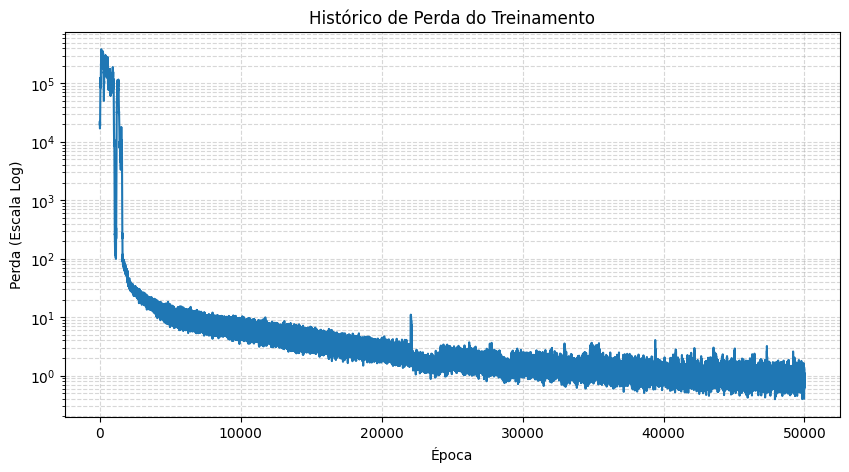

In [8]:
instance.plot_loss()

**Prever Trajetórias**

MSE:                  0.183143
MAE:                  0.395418
Erro Mínimo:          0.201539
Erro Máximo:          0.654838
Mediana dos Erros:    0.354994


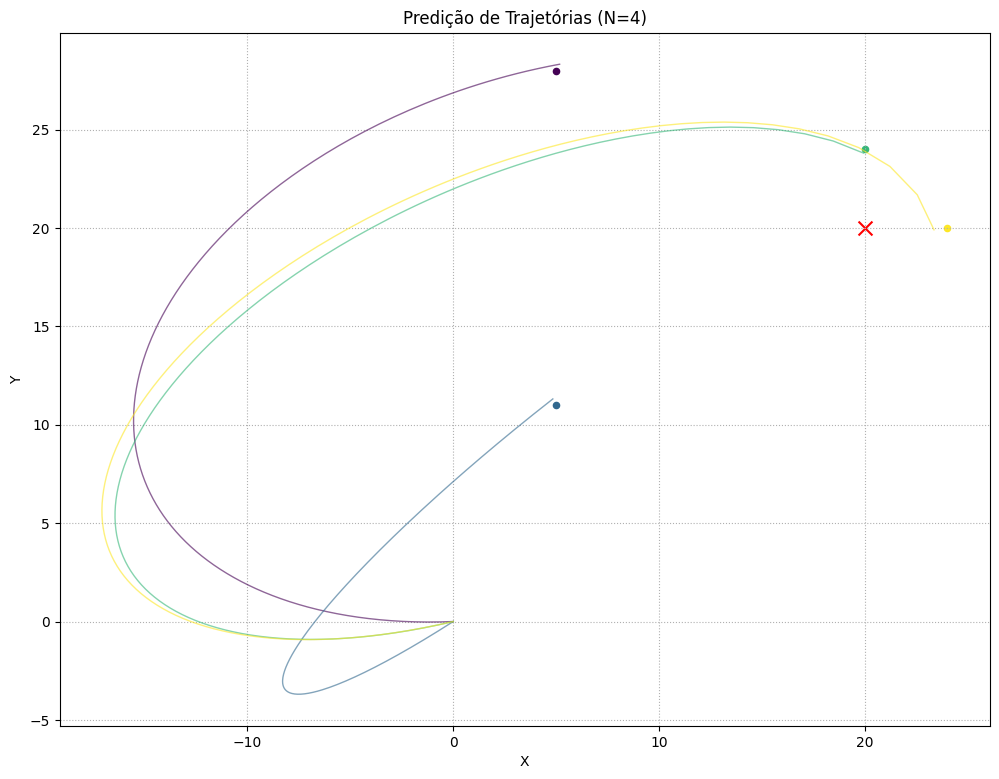

In [9]:
instance.predict([[5,28],[5,11],[20,24],[24,20]])

MSE:                  1.040534
MAE:                  0.585093
Erro Mínimo:          0.030775
Erro Máximo:          4.301101
Mediana dos Erros:    0.314315


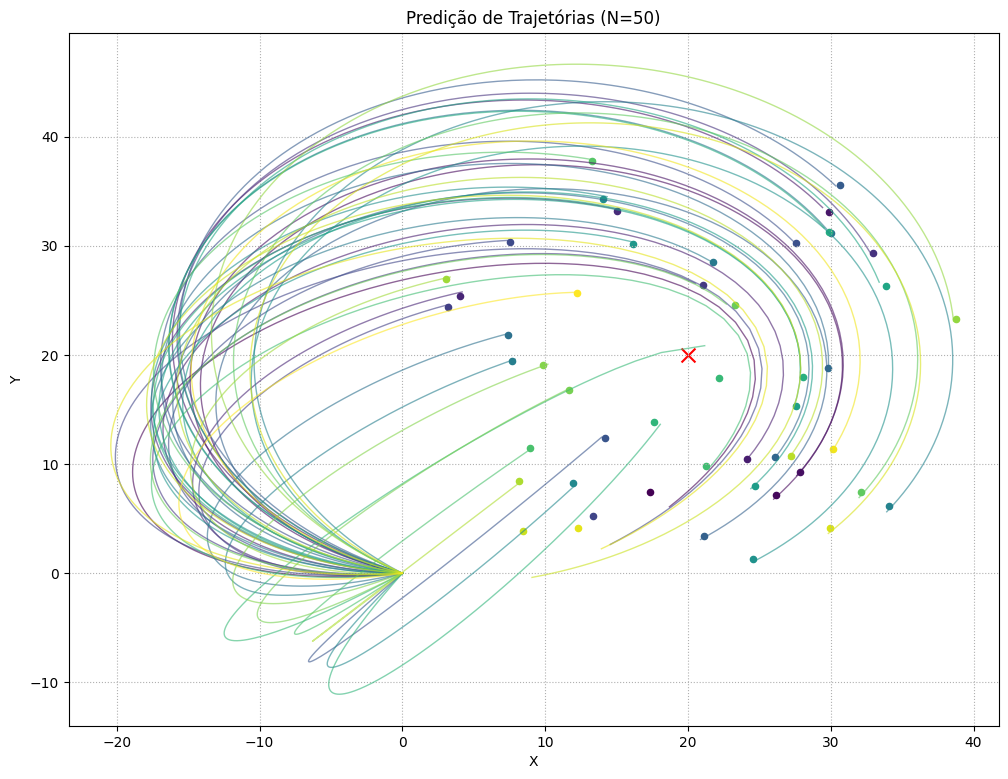

In [10]:
instance.predict(50)

In [11]:
instance.simulate()

---